In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Inspect single training

In [2]:
# train_folder = Path(
#     r"C:\Users\inserm\Documents\histo_sign\trainings\2024-03-12_15-30-06"
# )  # 4 signatures ppaint


train_folder = Path(r"C:\Users\inserm\Documents\histo_sign\trainings\2024-03-12_15-41-54")  # All signatures


# train_folder = Path(r"C:\Users\inserm\Documents\histo_sign\trainings\2024-03-12_15-50-27")  # Selec signatures


# train_folder = Path(r"C:\Users\inserm\Documents\histo_sign\trainings\2024-03-12_15-54-02")  # Classic Basal


# train_folder = Path(r"C:\Users\inserm\Documents\histo_sign\trainings\2024-03-12_15-56-31")  # Stroma Activ/Ina


# train_folder = Path(r"C:\Users\inserm\Documents\histo_sign\trainings\2024-03-12_16-01-52")  # Hwang only

In [3]:
# Open the txt file a dictionnary
with open(train_folder / "params.txt", "r") as file:
    params = file.readlines()
    params = eval(params[0])
params

{'batch_size': 32,
 'n_ep': 100,
 'lr': 0.0005,
 'n_tiles': 64,
 'return_sign': 'long',
 'use_cross_val': True,
 'n_workers': 0,
 'wd': 0.0005}

In [4]:
corr_df = pd.DataFrame()
for split in train_folder.glob("split_*"):
    split = split.name
    with open(train_folder / split / "val_corrs.npy", "rb") as file:
        corrs = np.load(file, allow_pickle=True)
        corrs = corrs.tolist()
        corrs = pd.DataFrame(corrs, index=[0])
        corrs["split"] = split
        corr_df = pd.concat([corr_df, corrs], axis=0)

corr_df.index = corr_df["split"]
corr_df = corr_df.drop(columns="split")
corr_df

,IMMU_Tcellatlas_CD4.CD8_c4_Tstr,IMMU_Tcellatlas_CD8_c5_Tisg,IMMU_Tcellatlas_CD8_Teff,IMMU_Tcellatlas_CD8_Tn,IMMU_Tcellatlas_CD4_c1_Treg,IMMU_Tcellatlas_CD4_c3_Tfh,IMMU_Tcellatlas_CD4_c0_Tcm,IMMU_Tcellatlas_CD4_Tn,CCCA_MetaProg_MP1.Cell.Cycle.G2.M,CCCA_MetaProg_MP2.Cell.Cycle.G1.S,...,PDAC_CSY20_Sig9,PDAC_CSY20_Sig12,Exocrine,Endocrine,Classic,StromaActiv,Basal,StromaActivInflam,Immune,StromaInactive
split,,,,,,,,,,,,,,,,,,,,,
split_0,-0.091206,-0.072453,-0.153324,-0.095172,-0.170761,-0.154947,-0.116925,-0.116282,-0.109822,-0.089781,...,-0.092751,-0.084958,-0.088445,-0.108686,0.001146,0.340872,0.306742,-0.070478,0.197902,0.150884
split_1,0.021084,0.069692,0.078931,-0.036237,0.173203,0.031954,0.039771,0.024226,-0.155085,-0.150653,...,-0.120515,-0.061935,0.235174,0.165522,0.129728,0.569106,0.009848,0.109689,0.279654,0.498148
split_2,-0.124658,-0.133557,-0.092561,-0.121262,-0.112722,-0.089469,-0.105643,-0.112402,-0.062288,-0.114378,...,-0.102199,-0.109316,-0.115080,0.146979,0.103778,-0.130157,-0.090436,-0.313658,-0.191919,0.467914
split_3,-0.080278,-0.110698,-0.126836,-0.135780,-0.109605,-0.138228,-0.114482,-0.119923,-0.070690,-0.112647,...,-0.140835,-0.117449,0.162633,0.146087,0.207942,0.142601,0.052664,-0.050948,0.043048,0.539263
split_4,0.065558,0.035086,0.159632,0.036143,0.335889,0.398980,0.147579,0.022585,0.212355,0.298685,...,0.242937,0.325282,0.181079,0.345201,-0.213390,0.241796,0.079309,-0.080889,0.156949,0.179455


<Axes: ylabel='split'>

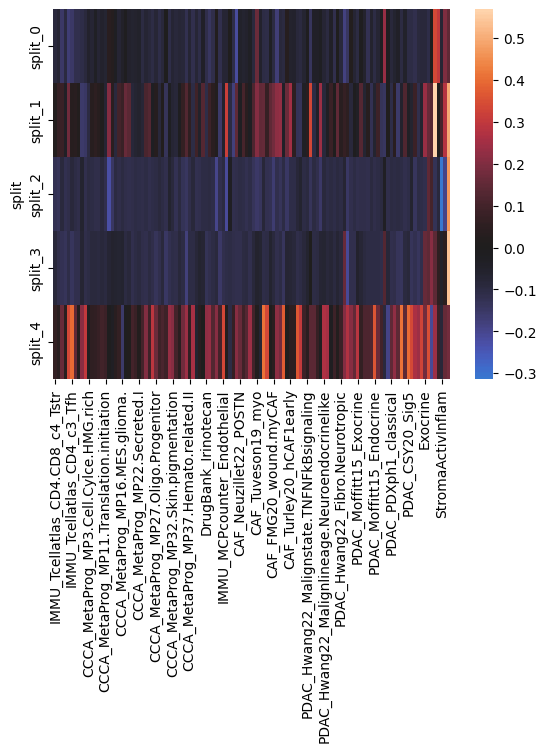

In [5]:
# Plot as a heatmap
sns.heatmap(corr_df, center=0)

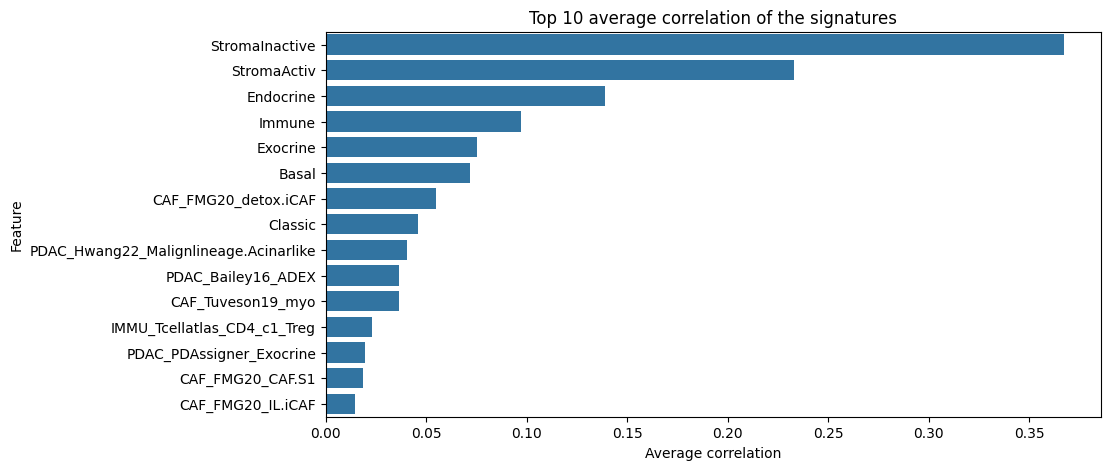

In [6]:
avg_corr = corr_df.mean(axis=0)
avg_corr = avg_corr.sort_values(ascending=False)

nb_top = 15

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=avg_corr[:nb_top], y=avg_corr.index[:nb_top], ax=ax)
ax.set_title("Average correlation of the top 10 signatures")
ax.set_title("Top 10 average correlation of the signatures")
ax.set_xlabel("Average correlation")
ax.set_ylabel("Feature")
plt.show()

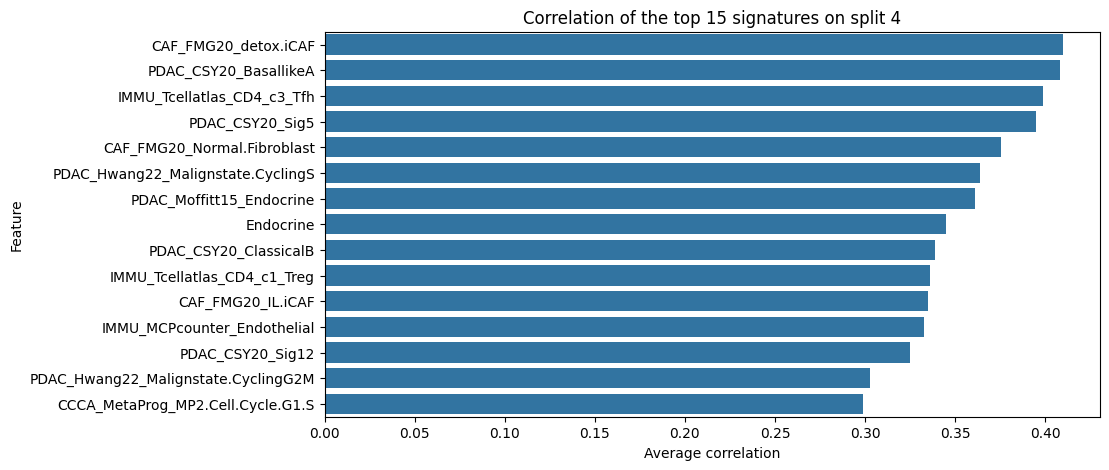

In [7]:
split_nb = 4
split_df = corr_df.loc[f"split_{split_nb}"]
split_df = split_df.sort_values(ascending=False)

nb_top = 15

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=split_df[:nb_top], y=split_df.index[:nb_top], ax=ax)
ax.set_title(f"Correlation of the top {nb_top} signatures on split {split_nb}")
ax.set_xlabel("Average correlation")
ax.set_ylabel("Feature")
plt.show()

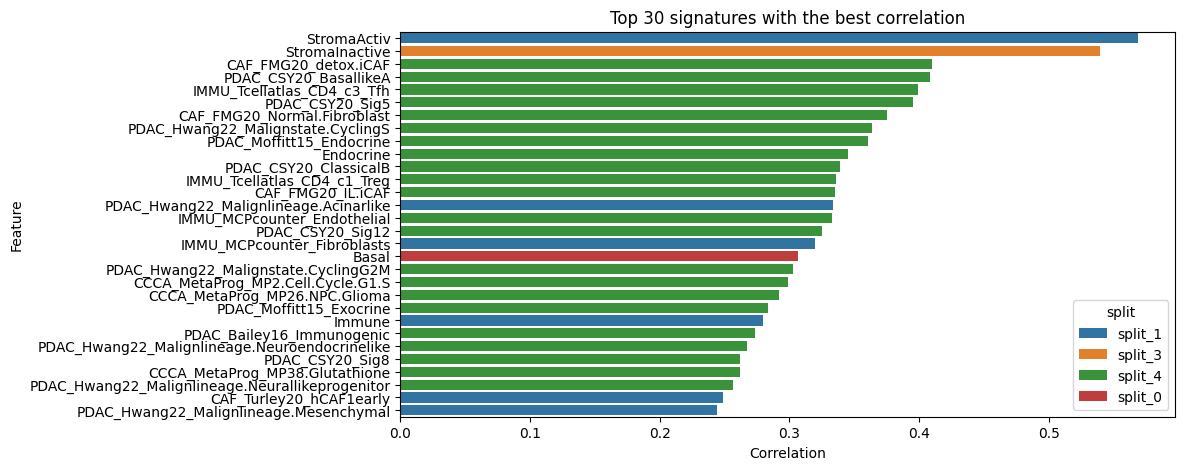

In [8]:
# Find the best split
best_split = corr_df.idxmax(axis=0).T
best_split = best_split.reset_index()
best_split.rename(columns={"index": "signature", 0: "split"}, inplace=True)
best_split["correlation"] = corr_df.max(axis=0).values
best_split.sort_values(by="correlation", ascending=False, inplace=True)
best_split.reset_index(drop=True, inplace=True)

n_top = 30
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(
    x=best_split["correlation"][:n_top],
    y=best_split["signature"][:n_top],
    ax=ax,
    hue=best_split["split"][:n_top],
)
ax.set_title(f"Top {n_top} signatures with the best correlation")
ax.set_xlabel("Correlation")
ax.set_ylabel("Feature")
plt.show()

In [9]:
best_split.to_csv(r"C:\Users\inserm\Documents\histo_sign\dataset\best_split.csv", index=False)

In [10]:
# new_col_to_pred = list(best_split[:n_top].signature.values)
# # new_col_to_pred = []
# new_col_to_pred += list(corr_df.filter(like="Hwang").columns.values)
# new_col_to_pred += ["Classic", "StromaActiv", "Basal", "StromaInactive"]
# new_col_to_pred = list(set(new_col_to_pred))
# np.savetxt(
#     Path(r"C:\Users\inserm\Documents\histo_sign\dataset\new_col_names.txt"),
#     new_col_to_pred,
#     fmt="%s",
#     encoding="utf-8",
# )

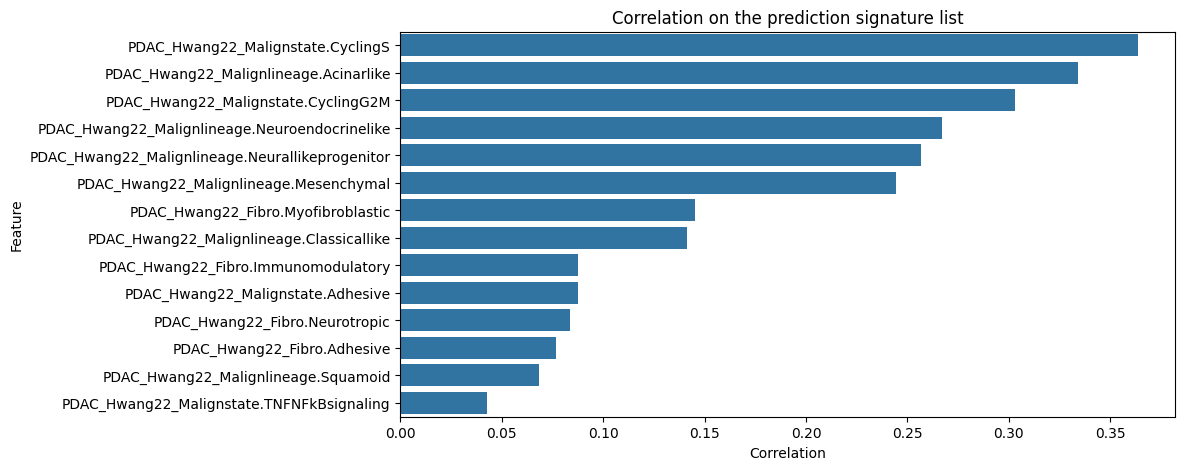

In [11]:
new_col_to_pred = np.loadtxt(
    Path(r"C:\Users\inserm\Documents\histo_sign\dataset\new_col_names.txt"),
    dtype=str,
    encoding="utf-8",
)
new_pred = best_split[best_split.signature.isin(new_col_to_pred)]
# plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=new_pred["correlation"], y=new_pred["signature"], ax=ax)
ax.set_title("Correlation on the prediction signature list")
ax.set_xlabel("Correlation")
ax.set_ylabel("Feature")
plt.show()

# All signatures training

In [3]:
# folder_path = Path(r"C:\Users\inserm\Documents\histo_sign\trainings\single_signatures\2024-03-15_15-44-10") # selected signatures
folder_path = Path(
    r"C:\Users\inserm\Documents\histo_sign\trainings\single_signatures\2024-03-15_16-00-21"
)  # all signatures

In [4]:
sign_path = list(folder_path.glob("*"))
sign_path = [x for x in sign_path if x.is_dir()]
sign_name = [x.name for x in sign_path]
recap_df = pd.DataFrame({"signature": sign_name, "path": sign_path})

In [5]:
def get_sgn(row):
    corr_sgn = {}
    for k in range(0, 5):
        val_corr = np.load(row.path / f"split_{k}" / "val_corrs.npy", allow_pickle=True)
        val_corr = val_corr.tolist()
        # print(val_corr.keys())
        if row.signature in val_corr:
            val_corr = val_corr[row.signature]
        elif row.signature == "CCCA_MetaProg_MP16.MES.glioma":
            val_corr = val_corr["CCCA_MetaProg_MP16.MES.glioma."]
        elif row.signature == "CCCA_MetaProg_MP17.Interferon.MHC.II.I":
            val_corr = val_corr["CCCA_MetaProg_MP17.Interferon.MHC.II.I."]
        elif row.signature == "CCCA_MetaProg_MP18.Interferon.MHC.II.II":
            val_corr = val_corr["CCCA_MetaProg_MP18.Interferon.MHC.II.II."]
        elif row.signature == "CCCA_MetaProg_MP7.Stress.in.vitro":
            val_corr = val_corr["CCCA_MetaProg_MP7.Stress.in.vitro."]
        else:
            raise ValueError(f"{row.signature} not found in {val_corr.keys()}")
        corr_sgn[f"split_{k}"] = val_corr
    return corr_sgn


res = recap_df.apply(get_sgn, axis=1, result_type="expand")
recap_df = pd.concat([recap_df, res], axis=1)

In [6]:
recap_df["mean_corr"] = recap_df.filter(like="split_").mean(axis=1)
recap_df["best_split"] = recap_df.filter(like="split_").idxmax(axis=1)
recap_df["best_corr"] = recap_df.filter(like="split_").max(axis=1)
recap_df["model_path"] = recap_df.apply(lambda x: x.path / x.best_split / "model.pth", axis=1)
recap_df.sort_values(by="best_corr", ascending=False, inplace=True)
recap_df.reset_index(drop=True, inplace=True)

In [7]:
selected_sign = np.loadtxt(
    r"C:\Users\inserm\Documents\histo_sign\dataset\selected_col_names.txt", dtype=str, encoding="utf-8"
)
recap_df["selected"] = recap_df.signature.isin(selected_sign)

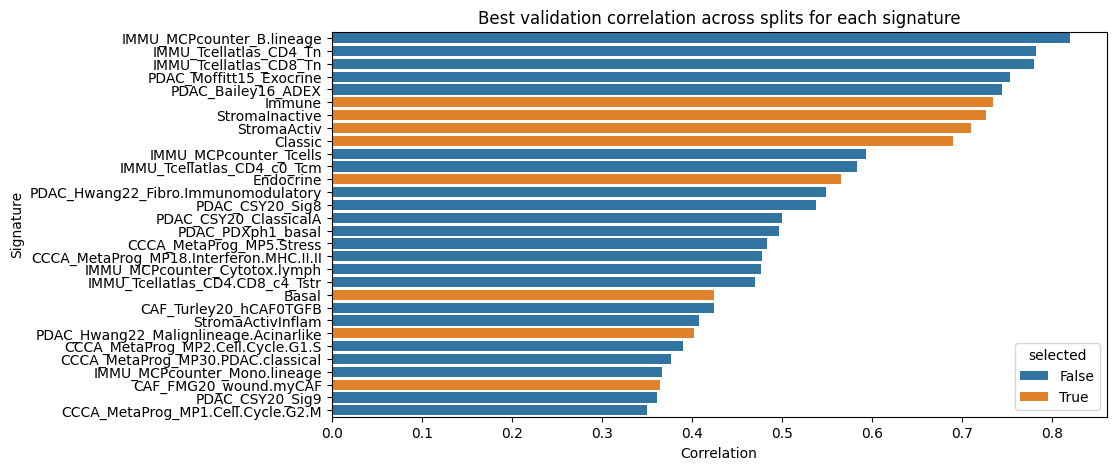

In [8]:
# plot
n_top = 30
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(
    x=recap_df["best_corr"][:n_top], y=recap_df["signature"][:n_top], ax=ax, hue=recap_df["selected"][:n_top]
)
ax.set_title("Best validation correlation across splits for each signature")
ax.set_xlabel("Correlation")
ax.set_ylabel("Signature")
plt.show()

In [35]:
valid_model = recap_df[:10]
valid_sign = valid_model.signature.values
valid_sign = list(set(valid_sign).union(set(["Classic", "StromaActiv", "Basal", "StromaInactive"])))
valid_model = recap_df[recap_df.signature.isin(valid_sign)]

res = valid_model[["signature", "model_path"]]
res_dict = res.set_index("signature").T.to_dict("list")
for k, v in res_dict.items():
    res_dict[k] = v[0].as_posix()

np.save(r"C:\Users\inserm\Documents\histo_sign\dataset\best_model_path.npy", res_dict)